In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#Import basic libraries
%matplotlib inline


import os
import sys
import settings
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from django_pandas.io import read_frame
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates

from matplotlib.dates import date2num

In [3]:
#Prepare to load stock data as pandas dataframe from source. In this case, prepare django
import django
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'rest.settings')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

from stocks.models import Listing, Stock

In [4]:
#Asian paints
sid = 'ASIANPAINT'
stock = Stock.objects.get(sid=sid)

print (stock.sid)
print(stock.security)
print (stock)


ASIANPAINT
500820
ASIAN PAINTS LTD.


In [5]:
#Read data into a dataframe
listings = Listing.objects.filter(stock=stock)
df = read_frame(listings, index_col='date')
for column in df.columns:
    if column != 'stock':
       df[column] = pd.to_numeric(df[column]) 
df = df.sort_index()
df = df.reindex(columns = ['opening', 'high', 'low', 'closing', 'traded'])
df.rename(columns={"opening": "Open", "high": "High", "low": "Low", "closing":"Close", "traded":"Volume"}, inplace=True)

In [6]:
#Optionally, filter out by date range
start_date = '2020-01-01'
end_date = '2021-12-31'
ticker = 'ASIANPAINTS'

df = df.loc[start_date:end_date]

In [33]:
df.head()

,Open,High,Low,Close,Volume,RSI
date,,,,,,
2020-01-01,1790.15,1803.0,1785.00,1793.75,32156,57.881562
2020-01-02,1790.60,1800.0,1785.00,1790.25,22940,56.608454
2020-01-03,1788.00,1788.0,1747.25,1751.65,26202,44.883401
2020-01-06,1744.90,1744.9,1694.00,1707.50,68842,35.759960
2020-01-07,1708.30,1740.8,1708.30,1723.90,20856,40.590818


In [7]:
#Import TA-lib and backtesting library
import talib
from talib.abstract import *
from talib import MA_Type

from backtesting import Strategy
from backtesting.lib import crossover

/mnt/c/Users/anshu/Documents/experimental/env/lib/python3.8/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [22]:
#Create a strategy
class SmaCross(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 20
    n2 = 200
    
    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.data.Close, int(self.n1))
        self.sma2 = self.I(SMA, self.data.Close, int(self.n2))
    
    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()

In [23]:
from backtesting import Backtest

bt = Backtest(df, SmaCross, cash=10_000, commission=.002)
stats = bt.run()
stats

Start                     2015-10-13 00:00:00
End                       2021-08-03 00:00:00
Duration                   2121 days 00:00:00
Exposure Time [%]                   80.130058
Equity Final [$]                    6717.6241
Equity Peak [$]                     10786.563
Return [%]                         -32.823759
Buy & Hold Return [%]              249.714088
Return (Ann.) [%]                   -6.987938
Volatility (Ann.) [%]               20.005844
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -60.927182
Avg. Drawdown [%]                  -16.895672
Max. Drawdown Duration     1686 days 00:00:00
Avg. Drawdown Duration      427 days 00:00:00
# Trades                                   16
Win Rate [%]                             25.0
Best Trade [%]                      68.290869
Worst Trade [%]                    -15.263812
Avg. Trade [%]                    

In [24]:
bt.plot()

Row(id='3646', ...)

In [26]:
%%time

stats = bt.optimize(n1=range(5, 30, 5),
                    n2=range(20, 200, 5),
                    maximize='Equity Final [$]',
                    constraint=lambda param: param.n1 < param.n2)
stats

CPU times: user 62.5 ms, sys: 219 ms, total: 281 ms
Wall time: 1.94 s


Start                     2015-10-13 00:00:00
End                       2021-08-03 00:00:00
Duration                   2121 days 00:00:00
Exposure Time [%]                   94.075145
Equity Final [$]                   19074.2411
Equity Peak [$]                    20969.8211
Return [%]                          90.742411
Buy & Hold Return [%]              249.714088
Return (Ann.) [%]                   12.477097
Volatility (Ann.) [%]               27.435516
Sharpe Ratio                         0.454779
Sortino Ratio                        0.808884
Calmar Ratio                         0.318146
Max. Drawdown [%]                  -39.218088
Avg. Drawdown [%]                   -4.043567
Max. Drawdown Duration     1135 days 00:00:00
Avg. Drawdown Duration       49 days 00:00:00
# Trades                                   34
Win Rate [%]                        44.117647
Best Trade [%]                      45.357597
Worst Trade [%]                    -11.000998
Avg. Trade [%]                    

In [27]:
stats._strategy

<Strategy SmaCross(n1=25,n2=45)>

In [28]:
bt.plot(plot_volume=False, plot_pl=False)

Row(id='4255', ...)

In [31]:
import pandas as pd
from backtesting.lib import SignalStrategy, TrailingStrategy


class SmaCross(SignalStrategy,
               TrailingStrategy):
    n1 = 10
    n2 = 25
    
    def init(self):
        # In init() and in next() it is important to call the
        # super method to properly initialize the parent classes
        super().init()
        
        # Precompute the two moving averages
        sma1 = self.I(SMA, self.data.Close, int(self.n1))
        sma2 = self.I(SMA, self.data.Close, int(self.n2))
        
        # Where sma1 crosses sma2 upwards. Diff gives us [-1,0, *1*]
        signal = (pd.Series(sma1) > sma2).astype(int).diff().fillna(0)
        signal = signal.replace(-1, 0)  # Upwards/long only
        
        # Use 95% of available liquidity (at the time) on each order.
        # (Leaving a value of 1. would instead buy a single share.)
        entry_size = signal * .95
                
        # Set order entry sizes using the method provided by 
        # `SignalStrategy`. See the docs.
        self.set_signal(entry_size=entry_size)
        
        # Set trailing stop-loss to 2x ATR using
        # the method provided by `TrailingStrategy`
        self.set_trailing_sl(2)

In [32]:
bt = Backtest(df, SmaCross, commission=.002)
bt.run()
bt.plot()

Row(id='5817', ...)

In [33]:
%%time

stats = bt.optimize(n1=range(5, 30, 5),
                    n2=range(20, 200, 5),
                    maximize='Equity Final [$]',
                    constraint=lambda param: param.n1 < param.n2)
stats

CPU times: user 62.5 ms, sys: 250 ms, total: 312 ms
Wall time: 2.44 s


Start                     2015-10-13 00:00:00
End                       2021-08-03 00:00:00
Duration                   2121 days 00:00:00
Exposure Time [%]                    47.83237
Equity Final [$]                   21379.7407
Equity Peak [$]                    21379.7407
Return [%]                         113.797407
Buy & Hold Return [%]              249.714088
Return (Ann.) [%]                   14.838404
Volatility (Ann.) [%]               17.617183
Sharpe Ratio                         0.842269
Sortino Ratio                        1.662197
Calmar Ratio                         1.138319
Max. Drawdown [%]                  -13.035366
Avg. Drawdown [%]                   -2.769396
Max. Drawdown Duration      365 days 00:00:00
Avg. Drawdown Duration       43 days 00:00:00
# Trades                                   38
Win Rate [%]                        57.894737
Best Trade [%]                      19.585669
Worst Trade [%]                     -8.467861
Avg. Trade [%]                    

In [34]:
stats._strategy

<Strategy SmaCross(n1=5,n2=20)>

In [35]:
bt.plot(plot_volume=False, plot_pl=False)

Row(id='6547', ...)

In [47]:
from backtesting import Strategy, Backtest
from backtesting.lib import resample_apply


class System(Strategy):
    d_rsi = 14  # Daily RSI lookback periods
    w_rsi = 14  # Weekly
    level = 70
    
    def init(self):
        # Compute moving averages the strategy demands
        self.ma10 = self.I(SMA, self.data.Close, int(10))
        self.ma20 = self.I(SMA, self.data.Close, int(20))
        self.ma50 = self.I(SMA, self.data.Close, int(50))
        self.ma100 = self.I(SMA, self.data.Close, int(100))
        
        # Compute daily RSI(30)
        self.daily_rsi = self.I(talib.RSI, self.data.Close, self.d_rsi)
        
        # To construct weekly RSI, we can use `resample_apply()`
        # helper function from the library
        self.weekly_rsi = resample_apply(
            'W-FRI', talib.RSI, self.data.Close, self.w_rsi)
        
        
    def next(self):
        price = self.data.Close[-1]
        
        # If we don't already have a position, and
        # if all conditions are satisfied, enter long.
        if (not self.position and
            self.daily_rsi[-1] > self.level and
            self.weekly_rsi[-1] > self.level and
            self.weekly_rsi[-1] > self.daily_rsi[-1] and
            self.ma10[-1] > self.ma20[-1] > self.ma50[-1] > self.ma100[-1] and
            price > self.ma10[-1]):
            
            # Buy at market price on next open, but do
            # set 8% fixed stop loss.
            self.buy(sl=.92 * price)
        
        # If the price closes 2% or more below 10-day MA
        # close the position, if any.
        elif price < .98 * self.ma10[-1]:
            self.position.close()

In [45]:
backtest = Backtest(df, System, commission=.002)
backtest.run()

Start                     2015-10-13 00:00:00
End                       2021-08-03 00:00:00
Duration                   2121 days 00:00:00
Exposure Time [%]                    8.020231
Equity Final [$]                    9945.7925
Equity Peak [$]                    10501.6925
Return [%]                          -0.542075
Buy & Hold Return [%]              249.714088
Return (Ann.) [%]                   -0.098921
Volatility (Ann.) [%]                4.993294
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -9.786368
Avg. Drawdown [%]                   -2.912648
Max. Drawdown Duration     1606 days 00:00:00
Avg. Drawdown Duration      305 days 00:00:00
# Trades                                    7
Win Rate [%]                        28.571429
Best Trade [%]                       9.406701
Worst Trade [%]                     -3.406653
Avg. Trade [%]                    

In [46]:
backtest.plot()

Row(id='9290', ...)

In [48]:
%%time

backtest.optimize(d_rsi=range(10, 35, 5),
                  w_rsi=range(10, 35, 5),
                  level=range(30, 80, 10))

CPU times: user 93.8 ms, sys: 250 ms, total: 344 ms
Wall time: 1.84 s


Start                     2015-10-13 00:00:00
End                       2021-08-03 00:00:00
Duration                   2121 days 00:00:00
Exposure Time [%]                   31.864162
Equity Final [$]                    15257.675
Equity Peak [$]                     16022.585
Return [%]                           52.57675
Buy & Hold Return [%]              249.714088
Return (Ann.) [%]                    7.996512
Volatility (Ann.) [%]               12.864506
Sharpe Ratio                         0.621595
Sortino Ratio                        1.109071
Calmar Ratio                         0.446262
Max. Drawdown [%]                   -17.91887
Avg. Drawdown [%]                   -3.284559
Max. Drawdown Duration      665 days 00:00:00
Avg. Drawdown Duration       86 days 00:00:00
# Trades                                   21
Win Rate [%]                        52.380952
Best Trade [%]                       27.20492
Worst Trade [%]                     -3.981966
Avg. Trade [%]                    

In [49]:
backtest.plot()

Row(id='10307', ...)

 `argrelextrema` is used for detecting peaks in SciPy's signal processing library, and `deque` is like a fixed-length list that will drop the oldest entry and keep the new ones if you exceed its length. We'll use the first to spot our extrema in our data, then cycle through them and keep the points that are higher than the previous entries.

To spot our extrema, we need to pass an argument called order. This defines how many points on either side of our peak we need to actually label something a peak. So with order=5, we need something to be the highest point within 5-data points to the right and left. The other argument we provide is K, which is simply an integer to determine how many consecutive peaks we want to identify to determine a trend of higher highs.

In [35]:
#RSI Divergence strategy
#https://raposa.trade/blog/test-and-trade-rsi-divergence-in-python

from scipy.signal import argrelextrema
from collections import deque

def getHigherLows(data: np.array, order=5, K=2):
  '''
  Finds consecutive higher lows in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive lows need to be higher.
  '''
  # Get lows
  low_idx = argrelextrema(data, np.less, order=order)[0]
  lows = data[low_idx]
  # Ensure consecutive lows are higher than previous lows
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(low_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if lows[i] < lows[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getLowerHighs(data: np.array, order=5, K=2):
  '''
  Finds consecutive lower highs in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive highs need to be lower.
  '''
  # Get highs
  high_idx = argrelextrema(data, np.greater, order=order)[0]
  highs = data[high_idx]
  # Ensure consecutive highs are lower than previous highs
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(high_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if highs[i] > highs[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getHigherHighs(data: np.array, order=5, K=2):
  '''
  Finds consecutive higher highs in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive highs need to be higher.
  '''
  # Get highs
  high_idx = argrelextrema(data, np.greater, order=5)[0]
  highs = data[high_idx]
  # Ensure consecutive highs are higher than previous highs
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(high_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if highs[i] < highs[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getLowerLows(data: np.array, order=5, K=2):
  '''
  Finds consecutive lower lows in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive lows need to be lower.
  '''
  # Get lows
  low_idx = argrelextrema(data, np.less, order=order)[0]
  lows = data[low_idx]
  # Ensure consecutive lows are lower than previous lows
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(low_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if lows[i] > lows[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema


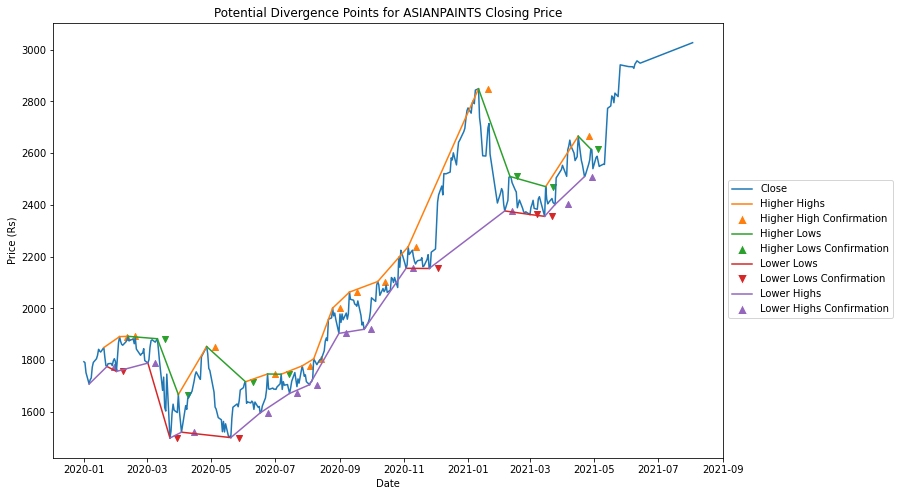

In [36]:
from matplotlib.lines import Line2D # For legend
price = df['Close'].values
dates = df.index
# Get higher highs, lower lows, etc.
order = 5
hh = getHigherHighs(price, order)
lh = getLowerHighs(price, order)
ll = getLowerLows(price, order)
hl = getHigherLows(price, order)
# Get confirmation indices
hh_idx = np.array([i[1] + order for i in hh])
lh_idx = np.array([i[1] + order for i in lh])
ll_idx = np.array([i[1] + order for i in ll])
hl_idx = np.array([i[1] + order for i in hl])
# Plot results
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(12, 8))
plt.plot(df['Close'])
plt.scatter(dates[hh_idx], price[hh_idx-order], marker='^', c=colors[1])
plt.scatter(dates[lh_idx], price[lh_idx-order], marker='v', c=colors[2])
plt.scatter(dates[ll_idx], price[ll_idx-order], marker='v', c=colors[3])
plt.scatter(dates[hl_idx], price[hl_idx-order], marker='^', c=colors[4])
_ = [plt.plot(dates[i], price[i], c=colors[1]) for i in hh]
_ = [plt.plot(dates[i], price[i], c=colors[2]) for i in lh]
_ = [plt.plot(dates[i], price[i], c=colors[3]) for i in ll]
_ = [plt.plot(dates[i], price[i], c=colors[4]) for i in hl]
plt.xlabel('Date')
plt.ylabel('Price (Rs)')
plt.title(f'Potential Divergence Points for {ticker} Closing Price')
legend_elements = [
  Line2D([0], [0], color=colors[0], label='Close'),
  Line2D([0], [0], color=colors[1], label='Higher Highs'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[1],
         label='Higher High Confirmation'),
  Line2D([0], [0], color=colors[2], label='Higher Lows'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[2],
         label='Higher Lows Confirmation'),
  Line2D([0], [0], color=colors[3], label='Lower Lows'),
  Line2D([0], [0], color='w',  marker='v',
         markersize=10,
         markerfacecolor=colors[3],
         label='Lower Lows Confirmation'),
  Line2D([0], [0], color=colors[4], label='Lower Highs'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[4],
         label='Lower Highs Confirmation')
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1, 0.65))
plt.show()

In [37]:
#Compute the RSI of the data
rsi_duration = 14;
rsi = talib.RSI(df['Close'].values, rsi_duration)
df['RSI'] =  rsi

rsi_hh = getHigherHighs(rsi, order)
rsi_lh = getLowerHighs(rsi, order)
rsi_ll = getLowerLows(rsi, order)
rsi_hl = getHigherLows(rsi, order)

# Get confirmation indices
rsi_hh_idx = np.array([i[1] + order for i in rsi_hh])
rsi_lh_idx = np.array([i[1] + order for i in rsi_lh])
rsi_ll_idx = np.array([i[1] + order for i in rsi_ll])
rsi_hl_idx = np.array([i[1] + order for i in rsi_hl])

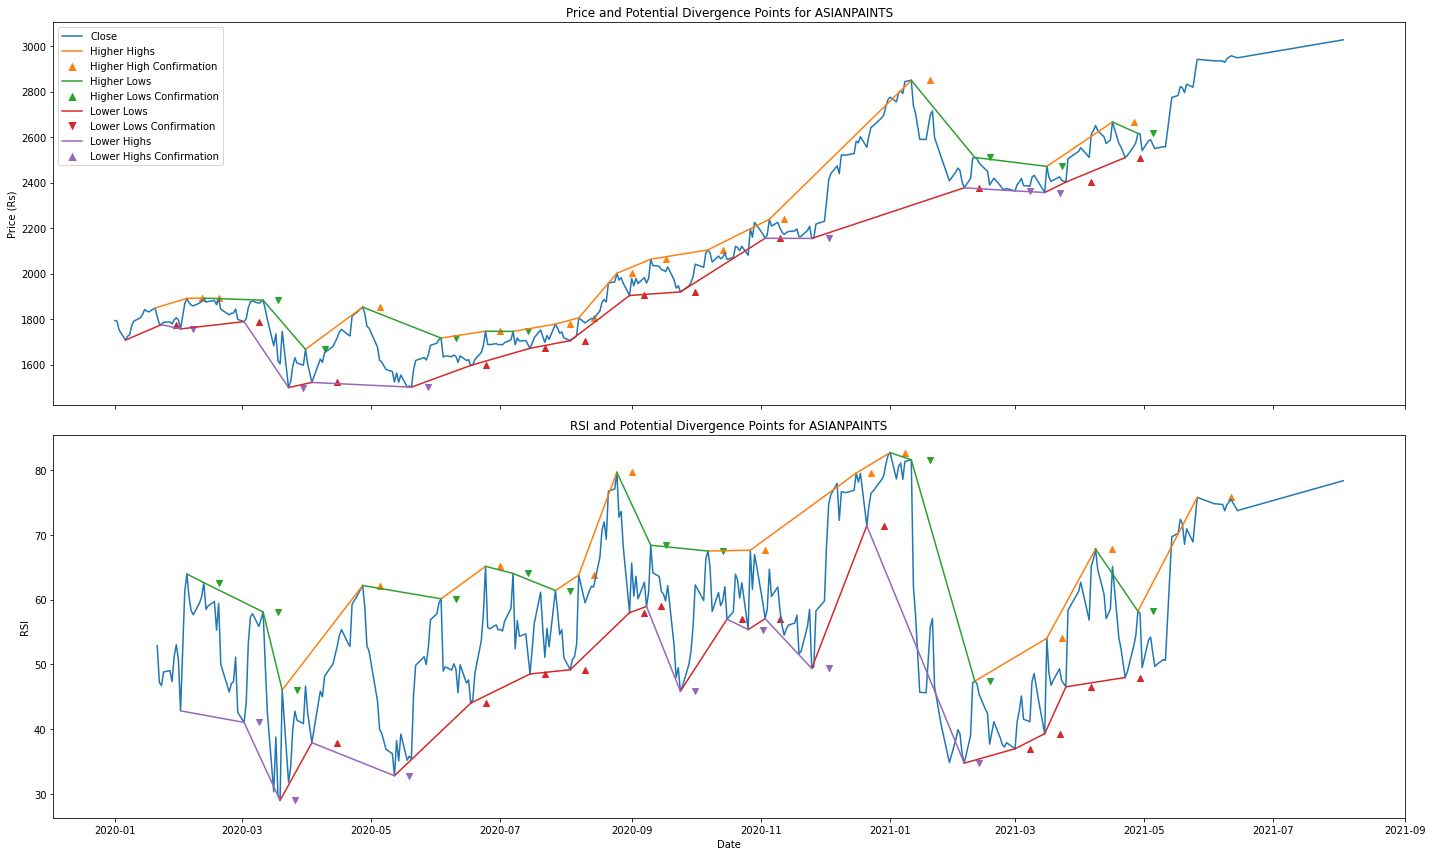

In [38]:
fig, ax = plt.subplots(2, figsize=(20, 12), sharex=True)
ax[0].plot(df['Close'])
ax[0].scatter(dates[hh_idx], price[hh_idx-order], 
              marker='^', c=colors[1])
ax[0].scatter(dates[lh_idx], price[lh_idx-order],
              marker='v', c=colors[2])
ax[0].scatter(dates[hl_idx], price[hl_idx-order],
              marker='^', c=colors[3])
ax[0].scatter(dates[ll_idx], price[ll_idx-order],
              marker='v', c=colors[4])
_ = [ax[0].plot(dates[i], price[i], c=colors[1]) for i in hh]
_ = [ax[0].plot(dates[i], price[i], c=colors[2]) for i in lh]
_ = [ax[0].plot(dates[i], price[i], c=colors[3]) for i in hl]
_ = [ax[0].plot(dates[i], price[i], c=colors[4]) for i in ll]
ax[0].set_ylabel('Price (Rs)')
ax[0].set_title(f'Price and Potential Divergence Points for {ticker}')
ax[0].legend(handles=legend_elements)
ax[1].plot(df['RSI'])
ax[1].scatter(dates[rsi_hh_idx], rsi[rsi_hh_idx-order], 
              marker='^', c=colors[1])
ax[1].scatter(dates[rsi_lh_idx], rsi[rsi_lh_idx-order],
              marker='v', c=colors[2])
ax[1].scatter(dates[rsi_hl_idx], rsi[rsi_hl_idx-order],
              marker='^', c=colors[3])
ax[1].scatter(dates[rsi_ll_idx], rsi[rsi_ll_idx-order],
              marker='v', c=colors[4])
_ = [ax[1].plot(dates[i], rsi[i], c=colors[1]) for i in rsi_hh]
_ = [ax[1].plot(dates[i], rsi[i], c=colors[2]) for i in rsi_lh]
_ = [ax[1].plot(dates[i], rsi[i], c=colors[3]) for i in rsi_hl]
_ = [ax[1].plot(dates[i], rsi[i], c=colors[4]) for i in rsi_ll]
ax[1].set_ylabel('RSI')
ax[1].set_title(f'RSI and Potential Divergence Points for {ticker}')
ax[1].set_xlabel('Date')
plt.tight_layout()
plt.show() 

In [39]:
#RSI Divergence strategy
def getHHIndex(data: np.array, order=5, K=2):
  extrema = getHigherHighs(data, order, K)
  idx = np.array([i[-1] + order for i in extrema])
  return idx[np.where(idx<len(data))]

def getLHIndex(data: np.array, order=5, K=2):
  extrema = getLowerHighs(data, order, K)
  idx = np.array([i[-1] + order for i in extrema])
  return idx[np.where(idx<len(data))]

def getLLIndex(data: np.array, order=5, K=2):
  extrema = getLowerLows(data, order, K)
  idx = np.array([i[-1] + order for i in extrema])
  return idx[np.where(idx<len(data))]

def getHLIndex(data: np.array, order=5, K=2):
  extrema = getHigherLows(data, order, K)
  idx = np.array([i[-1] + order for i in extrema])
  return idx[np.where(idx<len(data))]

def getPeaks(data, key='Close', order=5, K=2):
  vals = data[key].values
  hh_idx = getHHIndex(vals, order, K)
  lh_idx = getLHIndex(vals, order, K)
  ll_idx = getLLIndex(vals, order, K)
  hl_idx = getHLIndex(vals, order, K)

  data[f'{key}_highs'] = np.nan
  data[f'{key}_highs'][hh_idx] = 1
  data[f'{key}_highs'][lh_idx] = -1
  data[f'{key}_highs'] = data[f'{key}_highs'].ffill().fillna(0)
  data[f'{key}_lows'] = np.nan
  data[f'{key}_lows'][ll_idx] = 1
  data[f'{key}_lows'][hl_idx] = -1
  data[f'{key}_lows'] = data[f'{key}_highs'].ffill().fillna(0)
  return data


In [67]:
from backtesting import Strategy
def getPeaks(data, key='Close', order=5, K=2):
    
    vals = data[key].values
    hh_idx = getHHIndex(vals, order, K)
    lh_idx = getLHIndex(vals, order, K)
    
    a = np.empty(vals.shape)
    a[:] = np.nan
    a[hh_idx] = 1
    a[lh_idx] = -1
    #a = a.ffill().fillna(0)
    a[np.isnan(a)] = 0
    return a

def getValleys(data, key='Close', order=5, K=2):
    vals = data[key].values
    ll_idx = getLLIndex(vals, order, K)
    hl_idx = getHLIndex(vals, order, K)
    
    a = np.empty(vals.shape)
    a[:] = np.nan
    a[ll_idx] = 1
    a[hl_idx] = -1
    #a = data[f'{key}_highs'].ffill().fillna(0)
    a[np.isnan(a)] = 0
    return a
    
#Create a strategy
class RsiDivergence(Strategy):
    '''
      Go long/short on price and RSI divergence.
      - Long if price to lower low and RSI to higher low with RSI < 50
      - Short if price to higher high and RSI to lower high with RSI > 50
      Sell if divergence disappears.
      Sell if the RSI crosses the centerline.
    '''
    rsi_level = 50
    order = 5
    K = 2
    rsi_period = 14
    
    ema_s = 50
    ema_l = 200
    
    
    def init(self):
        # Precompute the RSI
        self.ema_s = self.I(EMA, self.data.df['Close'], int(self.ema_s))
        self.ema_l = self.I(EMA, self.data.df['Close'], int(self.ema_l))
        self.data.df['RSI'] = talib.RSI(self.data.df['Close'], self.rsi_period)
        self.rsi = self.I(talib.RSI, self.data.df['Close'], self.rsi_period)
        
        self.entry_rsi = 0
        
        self.close_highs = self.I(getPeaks, self.data.df, key='Close', order=self.order, K=self.K)
        self.close_lows = self.I(getValleys, self.data.df, key='Close', order=self.order, K=self.K)
        
        self.rsi_highs = self.I(getPeaks, self.data.df, key='RSI', order=self.order, K=self.K)
        self.rsi_lows = self.I(getValleys, self.data.df, key='RSI', order=self.order, K=self.K)
    
    def next(self):
        price = self.data.Close[-1]
        if np.isnan(self.data.RSI[-1]):
            return
        
        if self.position is None: #We might be opening a position
            #Long if RSI is less than 50 and making higher high
            if self.close_lows[-1] == -1 and self.rsi_lows == 1: #Price makes lower low, indicator makes higher low (Positive divergence)
                if self.data.RSI[-1] < 50:
                    self.entry_rsi = self.data.RSI[-1].copy()
                    #self.buy(sl=.92 * price)
                    self.buy()       
            # Short if price to higher high and indicator to lower high
            elif self.close_highs[-1] == 1 and self.rsi_highs[-1] == -1: #Price making higher high, RSI making lower high (Negative divergence)
                if row['RSI'] > 50:
                    self.sell()
                    self.entry_rsi = self.data.RSI[-1].copy()
        # If current position is long
        elif self.position.is_long:
            if self.rsi[-1] < 50 and self.rsi[-1] < self.entry_rsi:
                pass
            else:
                self.position.close()
            #elif self.ema_s > self.ema_l:
            #    pass

        # If current position is short
        elif self.position.is_short:
            if self.rsi[-1] > 50 and self.rsi[-1] < self.entry_rsi:
                pass
            else:
                self.position.close()
                

In [68]:
from backtesting import Backtest

bt = Backtest(df, RsiDivergence, cash=10_000, commission=.002)
stats = bt.run()
stats


Start                     2020-01-01 00:00:00
End                       2021-08-03 00:00:00
Duration                    580 days 00:00:00
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]               68.769338
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

In [69]:
bt.plot()

Row(id='1600', ...)

## Bollinger band and RSI strategy

In [14]:
#https://kylelix7.github.io/Trading-Strategy-Technical-Analysis-with-Python-TA-Lib/
#Create a strategy
class BollingerBand(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    timeperiod = 20
    rsi_period = 14
    nbdevup = 2
    nbdevdn = 2
    
    def init(self):
        # Precompute the two moving averages
        self.rsi = self.I(talib.RSI, self.data.Close, int(self.rsi_period))
        self.up, self.mid, self.low = self.I(talib.BBANDS, self.data.Close, 
                                              timeperiod = int(self.timeperiod), 
                                              nbdevup = int(self.nbdevup),
                                             nbdevdn = int(self.nbdevdn),
                                             matype=0)
    
    def next(self):
        bbp = (self.data.Close[-1] - self.low[-1]) / (self.up[-1] - self.low[-1])
        if self.rsi[-1]>70 and bbp>1:
            self.position.close()
            self.sell()

        if self.rsi[-1]<30 and bbp<0:
            self.position.close()
            self.buy()

In [15]:
from backtesting import Backtest

bt = Backtest(df, BollingerBand, cash=10_000, commission=.002)
stats = bt.run()
stats

Start                     2020-01-01 00:00:00
End                       2021-12-31 00:00:00
Duration                    730 days 00:00:00
Exposure Time [%]                        89.0
Equity Final [$]                    7690.8376
Equity Peak [$]                     11823.184
Return [%]                         -23.091624
Buy & Hold Return [%]               88.540767
Return (Ann.) [%]                  -12.394633
Volatility (Ann.) [%]               24.210085
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -45.275367
Avg. Drawdown [%]                  -19.626264
Max. Drawdown Duration      498 days 00:00:00
Avg. Drawdown Duration      161 days 00:00:00
# Trades                                   24
Win Rate [%]                             25.0
Best Trade [%]                      16.495633
Worst Trade [%]                    -20.620862
Avg. Trade [%]                    